# <center> Projet d'Algorithme pour la Génomique
## <center> Développement d’une solution de mapping de données de séquençage à haut-débit sur un génome de référence
<center> Encadré par Nicolas Parisot et Sergio Peignier
<center> Grandidier Clément, Dvoretzki Svetlana, Dazy Margaux

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from collections import Counter 
import Bio
from Bio.Seq import Seq
from Bio import SeqIO
import pandas as pd

## I. Importation des données 

We decided to store the 1 500 000 reads of length 100 in a dictionnary with their id as key and the read as value. We also stored in a list all ids. It is easier to have acces to them that way. 

We did the same for the 15 chromosomes that compose the genome.

In [2]:
dict_reads = {}
reads_id = []
for seq_record in SeqIO.parse("single_Pfal_dat.fq", "fastq"):
    current_id = seq_record.id
    reads_id.append(current_id)
    dict_reads[current_id] = str(seq_record.seq)
print(len(reads_id))

1500000


In [3]:
chromosomes_id = []
dict_chromosomes={}
for seq_record in SeqIO.parse("GCF_000002765.5_GCA_000002765_genomic.fna", "fasta"):
    current_chromosome = seq_record.id
    chromosomes_id.append(current_chromosome)
    dict_chromosomes[current_chromosome] = str(seq_record.seq)
print(len(chromosomes_id))

15


## II. The suffix array
### A. The code

Below you will find the code for our implementation of the DC3 algorithm.

In [24]:
def counting_sort(input_list, index):
    """
    Sort the input_list using Radix Sort based on values at the specified index in tuples
    
    Args : 
        input_list (list of tuple of int) : the list to be sorted
        index (int) : The index of the tuple element to use for sorting
        
    Return : 
        list of tuple of int : the sorted list
    """
    length = len(input_list)
    # create a list containing values at the specified index
    list_index = [0]*length
    for i in range(length):
        list_index[i]=input_list[i][index]
    
    # find the maximum value
    x = max(list_index)
    
    # create a counting array to count occurences of each value
    count_arr= [0]*(x+1)
    
    # create an array to store the sorted elements
    sorted_arr=[0]*length
    j=0
 
    # count the occurences of each value 
    for i in range(0, length):
        value = list_index[i]
        count_arr[value] += 1  
    
    for i in range(1, len(count_arr)):
        count_arr[i] += count_arr[i - 1]
    
    # Sort the elements
    for i in range(length-1, -1, -1):
        value = list_index[i]
        sorted_arr[count_arr[value] - 1] = input_list[i]
        count_arr[value] -= 1

    return sorted_arr

def RadixSort(input_list):
    """
    Give the sorted list using Radix Sort
    
    Args : 
        input_list (list of tuple of int) : the array we want to sort
        
    Return : 
        list of tuple of int : the sorted list
    """
    
    max_length = len(input_list[0])
    for index in range(max_length -1, -1, -1):
        input_list = counting_sort(input_list,index)
    return input_list

In [25]:
def index_merge(input_sequence, index_0, index_12, dict_index12):
    """
    Merge index_0 and index_12 indexes following the algorithm given in class
    
    Args:
        input_sequence (list of int): the input string that has been converted to int
        index_0 (list of int) : list of indexes in which mod by 3 gives 0, sorted following R0 order
        index_12 (list of int) : list of indexes in which mod by 3 gives 1 or 2, sorted following R_sorted order
        dict_index (dict : map int over int) : indexes of index_12 as keys and index of the index_12 as values
        
        
    Return:
        list of int: the merging of index_0 and index_12
    """
        
    res=[]
    i=0
    j=0
    while i < len(index_0) and j < len(index_12):
        a = index_0[i]
        b = index_12[j]
        if input_sequence[a] < input_sequence[b]:
            res.append(a)
            i=i+1
        elif input_sequence[a] > input_sequence[b]:
            res.append(b)
            j=j+1
        else:
            if b%3==1:
                c = dict_index12[a+1]
                d = dict_index12[b+1]
                if c<d:
                    res.append(a)
                    i=i+1
                elif d<c:
                    res.append(b)
                    j=j+1
    
            if b%3==2:
                if input_sequence[a+1] < input_sequence[b+1]:
                    res.append(a)
                    i=i+1
                elif input_sequence[a+1] > input_sequence[b+1]:
                    res.append(b)
                    j=j+1
                if input_sequence[a+1] == input_sequence[b+1]:
                    c = dict_index12[a+2]
                    d = dict_index12[b+2]
                    if c<d:
                        res.append(a)
                        i=i+1
                    elif d<c:
                        res.append(b)
                        j=j+1
    if i == len(index_0):
        for index in index_12[j:]:
            res.append(index)
    elif j==len(index_12):
        for index in index_0[i:]:
            res.append(index)
    return res
                    
                    
            

In [26]:
def dc3(input_string):
    """
    Compute the suffix array using the DC3 algorithm.
    
    Args:
        input_string (str): the input string for which to compute the suffix array.
        input_string (list of int) : the input string is a list of int if dc3 has been called recursively
    Return:
        list of int: The suffix array.
    """

    # Step 0 : convert the input string to a list of integers if the input string is a string
    if type(input_string)==str:
        # check if the end of string character is present
        if input_string[-1]!="$":
            input_string = input_string + "$"
        input_sequence = [ord(char) for char in input_string]
    else:
        input_sequence = input_string.copy()
    input_sequence.extend((0,0,0)) #add sentinels
    
    # Step 1 : Split the sequence into three subsequences based on mod by 3
    input_seq_len=len(input_sequence)
    P0 = [i for i in range(input_seq_len-1) if ( i%3==0 and i+2<input_seq_len)]
    P1 = [i for i in range(input_seq_len-1) if ( i%3==1 and i+2<input_seq_len)]
    P2 = [i for i in range(input_seq_len-1) if ( i%3==2 and i+2<input_seq_len)]
    # concatenation of P1 and P2
    P12 = P1 + P2
    
    # create triplets (R12) of numbers starting from indexes P12 and sort them
    R12 = [(input_sequence[i], input_sequence[i+1], input_sequence[i+2]) for i in P12]
    R_sorted = RadixSort(R12)

    # Create a dict with triplets as keys and their order in R_sorted as value.
    dict_Rsorted_order = {}
    duplicate = False
    order = 1
    for triplet in R_sorted:
        if triplet not in dict_Rsorted_order:
            dict_Rsorted_order[triplet] = order
            order += 1
        else:
            duplicate = True


    # Create a dictionary with triplets as keys and a subdictionnary of their indexes (index of the first number of the triplet) as values.
    # If no duplicate, the subdictionnary is { 0 : index }
    # If duplicate, the subdictionnary is { 0 : index1, 1 : index2, ...}
    dict_triplet_index={}
    for i in range(len(P12)):
        if R12[i] not in dict_triplet_index:
            dict_triplet_index[R12[i]]={0:P12[i]}
        else:
            length=len(dict_triplet_index[R12[i]])
            dict_triplet_index[R12[i]][length]=P12[i]

    
    # Create the index_12 containing the original indexes of each triplet in sorted order
    index_12 = []
    dict_index12={} #keep in memory the index_12 as key and the index of the index_12 as value, it is for the R0 computation to make it faster
    i=0
    for triplet in R_sorted:
        current_key, current_index = dict_triplet_index[triplet].popitem()
        index_12.append(current_index)
        dict_index12[current_index] = i
        i += 1
    
    # If there are duplicate triplets, process T' and repeat recursively
    if duplicate:
        T_prime = []
        for elem in R12:
            T_prime.append(dict_Rsorted_order[elem])
        index_12=[]
        i=0
        dict_index12={}
        index_prime = dc3(T_prime)
        for ind in index_prime:
            index_12.append(P12[ind])
            dict_index12[P12[ind]]=i
            i+=1


    # Step 2 : Create R0 and sort it.
    R0 = []
    for num in P0:
        if num < len(input_string): #if num is a centinel, so if num=len(S), there is no triplet at index num+1
            R0.append([input_sequence[num],dict_index12[num+1]])       
    R0_sorted = RadixSort(R0) 

    # Create the index_0 list 
    index_0=[]
    for elem in R0_sorted:
        index_0.append(index_12[elem[1]]-1)


    # Step 3 : merge index_0 and index_12

    index_merged = index_merge(input_sequence,index_0,index_12, dict_index12)

    #Remove sentinel index. Index of sentinel is always len(input_string)
    new_index = index_merged
    if len(input_string) in new_index:
        new_index.remove(len(input_string))

        
    return new_index

### B. Time complexity of DC3

If we look closely to our DC3 algorithm we have the following complexities : with n = len(input_string)

- Step 0 : conversion of the input string into a list of integers. Complexity of O(n) in the worst case

- Step 1 : Creation of P0, P1, P2. 3 for loops that gives a complexity of O(n)

- Step 1 : RadixSort of R12. Complexity of O(n logn)

- Step 1 : Creation of dictionnaries. for loops giving a complexity of O(n)

- Step 1 : If duplication, for loops giving a complexity of O(n)

- Step 2 : Creation of R0 gives a complexity of O(n) and RadixSort gives a complexity of O(n logn)

- Step 3 : index_merge has a complexity of O(n)

In the end, the complexity of DC3 is O(n) in the best cases and can be slightly increased due to the recursion.

In [27]:
%%time
# Compute dc3 for every chromosome
dict_dc3_result = {}
for chromosome in chromosomes_id:
    print(chromosome) # we print the id of the chromosome to have an idea of which chromosome is being used
    dict_dc3_result[chromosome] = dc3(dict_chromosomes[chromosome])

NC_004325.2
NC_037280.1
NC_000521.4
NC_004318.2
NC_004326.2
NC_004327.3
NC_004328.3
NC_004329.3
NC_004330.2
NC_037281.1
NC_037282.1
NC_037284.1
NC_004331.3
NC_037283.1
NC_036769.1
CPU times: total: 10min 8s
Wall time: 11min


With my computer, it takes 11 minutes to compute the suffix array for every chromosome and store it into a dictionnary.

The following figure show the O(n) complexity of dc3 by increasing the length of the input string. The linearity is not clear because the time.time() method is not very consistant. However we can see a linear behavior.

In [53]:
list_index = np.linspace(1, len(dict_chromosomes[chromosomes_id[0]]), 10, dtype = int)
list_time = []
for index_max in list_index:
    st=time.time()
    dc3(dict_chromosomes[chromosomes_id[0]][:index_max])
    ed=time.time()
    list_time.append(ed-st) #ed-st gives the Wall time 

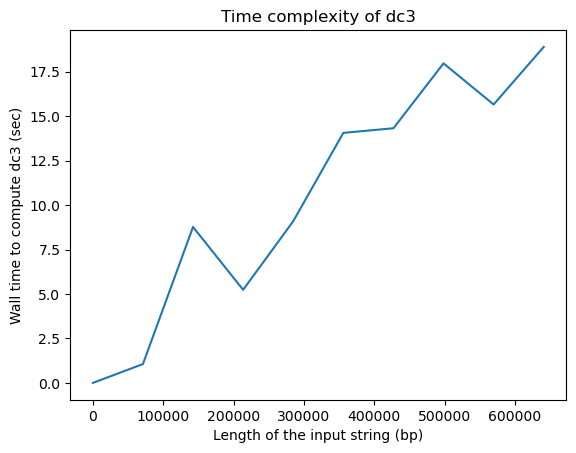

In [54]:
plt.plot(list_index, list_time)
plt.xlabel('Length of the input string (bp)')
plt.ylabel('Wall time to compute dc3 (sec)')
plt.title("Time complexity of dc3")
plt.show()

## III. The Burrows-Wheeler Transform (BWT)

Below you will find the code to perform the Burrows_Wheeler Transform of an input string by using the suffix array obtained using dc3. 

We have only one for loop so the complexity of this algorithm is O(n) with n = len(input_string).

In [28]:
def get_BWT(index_dc3, input_string):
    """
    Generate the Burrows-Wheeler Transform (BWT) of the input_string using the suffix array obtained with the DC3 algorithm
    
    Args : 
        index_dc3 (list of int) : the suffix array obtained using the DC3 algorithm
        input_string (str) : the input string
        
    Return : 
        str : the Burrows-Wheeler Transform (BWT) of the input string
    """
    # check if we have the end of string charcater
    if input_string[-1]!="$":
        input_string = input_string + "$"
        
    res=""
    for index in index_dc3:
        res += input_string[index-1]

    return res

## IV. String searching algorithm

Below you will find the code for the string searching algorithm. It is a modified version of the string search code given during the practical.

If we look at the complexity of this algorithm we can say :

- in the worst case the while loop is executed i times with i equals to the length of the substring

- inside the while loop, get_occurence_index and get_index_in_CSM1 are both of O(n) with n equals to the length of the text

In the end this algorithm has a complexity of O(i * n)

In [29]:
def get_occurence_index(text):
    """
    Generate an index of character occurrences in the input text
    
    Args : 
        text (str) : the input text
        
    Return :
        list of int : An index where the integer at index i represents the number of occurrences of the i-th character in the text
    """
    
    occurence_index = []
    occurence_counts = {}
    
    for char in text:
        # check if the character has been encountered before
        if char not in occurence_counts:
            occurence_counts[char]=0
        
        occurence_index.append(occurence_counts[char])
        occurence_counts[char]+=1
        
    return occurence_index

def get_index_in_CSM1(current_char, char_k, character_count):
    """
    Give the index of current_char in the 1st column of the Circular Shift Matrix (CSM1) 
    (Reminder : CSM1 is the lexical sorted BWT and characters indexing is preserved in CSM1, so char_k in BWT is char_k in CSM1)
    
    Args : 
        current_char (str) : The current character we are working with
        char_k (int) : k-th character of the current_char in the BWT
        character_count (collections.Counter) : Counter of every character present in the text
    
    Return : 
        int : index of current_char in CSM1
    """
    
    return char_k + sum([character_count[char] for char in character_count if char < current_char])

def get_first_occurence(text, current_char):
    """
    Give the index of the first occurence of current_char in text
    
    Args :
        bwt_result (str) : Result of the Burrows-Wheeler Transform (BWT) of text using the dc3 results
        current_char (str) : The current character we are looking for in text
        
    Return : 
        int : index of the first time we meet current_char in text
    
    """

    for i in range(len(text)):
        if text[i]==current_char:
            return i

def string_search(text, substring, dc3_result, bwt_result, occurence_counts, character_count):
    """
    Find how many times the substring is in text and if found give the position in the text of every occurence
    
    Args:
        text (str): the input text
        substring (str) : substring of length k to find in text
        dc3_result (list of int) : Result of the dc3 algorithm applied to text
        bwt_result (str) : Result of the Burrows-Wheeler Transform (BWT) of text using the dc3 results
        occurence_counts (list of int) : An index where the integer at index i represents the number of occurrences of the i-th character in the text
        character_count (collections.Counter) : Counter of every character present in the text
        
    Return:
        list of int : index of the first character of substring in text for every occurence
    """
    
    if text[-1] != "$":
        text = text + "$"
        
    e = 0
    f = len(bwt_result)
    i = len(substring)-1
    while e < f and i >= 0:
        current_char = substring[i]
        
        
        first_occurence_in_bwt = get_first_occurence(bwt_result[e:f],current_char)
        if first_occurence_in_bwt is None:
            return []
        else:
            r = first_occurence_in_bwt + e
            
        last_occurence_in_bwt = get_first_occurence(bwt_result[e:f][::-1],current_char)
        if last_occurence_in_bwt is None:
            return []
        else:
            s = f-last_occurence_in_bwt-1

        
        e = get_index_in_CSM1(current_char,occurence_counts[r],character_count)
        f = get_index_in_CSM1(current_char,occurence_counts[s],character_count)+1
        i -= 1
 
    position = []
    for j in range(r,s+1):
        if bwt_result[j]==substring[0]:
            position.append(dc3_result[j]-1)
    position = sorted(position)
    
    nb_occurences = f-e
    
    #print("Substring T is in S, it has been found ", nb_occurences, " times.")
    #print("Substring T in S can be found at ", position)

    return position


## V. Other code

In [30]:
def kmer(text, k):
    """
    Give every k-mer of length k of text
    
    Args : 
        text (str) : the input text
        k (int) : length of each k-mer
        
    Return : 
        list of str : list of every kmer of length k of text
    """
    res = []
    for i in range(len(text)-k+1):
        res.append(text[i:i+k])
    return res

In [31]:
def get_substring(text, i, k):
    """
    Give the substring of length k starting at position i in text
    """
    if i < len(text)-k+1:
        return text[i:i+k]

## VI. Main program

In [33]:
# Compute bwt, occurence_counts and character_count for every chromosome
dict_bwt_result = {}
dict_occurence_counts = {}
dict_character_count = {}
for chromosome in chromosomes_id:
    print(chromosome)
    dict_bwt_result[chromosome] = get_BWT(dict_dc3_result[chromosome], dict_chromosomes[chromosome])
    dict_occurence_counts[chromosome] = get_occurence_index(dict_bwt_result[chromosome])
    dict_character_count[chromosome] = Counter(dict_bwt_result[chromosome])
   

NC_004325.2
NC_037280.1
NC_000521.4
NC_004318.2
NC_004326.2
NC_004327.3
NC_004328.3
NC_004329.3
NC_004330.2
NC_037281.1
NC_037282.1
NC_037284.1
NC_004331.3
NC_037283.1
NC_036769.1


First we will create a main program that takes everything we've done before.

The goal here is to find the position of every read or its reverse complement on the chromosome (if it exists).

We decided to take only the first 100 000 reads because it takes a very long time to try all of them.

In [97]:
def main(dict_chromosomes, dict_reads, dict_dc3_result, dict_bwt_result, dict_occurence_counts, dict_character_count):
    """
    Give the position of the read or its reverse complement on its chromosome
    
    Args : 
        dict_chromosomes (dict str : str) : a dictionnary with chromosome id : chromosome sequence
        dict_reads (dict str : str) : a dictionnary with read id : read sequence
        dict_dc3_result (dict str : list of int) : a dictionnary with chromosome id : suffix array of chromosome
        dict_bwt_result (dict str : str) : a dictionnary with chromosome id : BWT of chromosome
        dict_occurence_counts (dict str : list of int) : a dictionnary with chromosome id : index of character occurrences
        dict_character_count (dict str : collections.Counter) : a dictionnary with chromosome id : Counter of every character present in chromosome
 
    Return : 
        list of str : each string is the read_id + 0 or 16 + list of position (index)
        0 is the read itself, 16 is its reverse complement
    """
    res = []
    i = 0
    for read_id, read_seq in dict_reads.items():
        chrom = read_id[:11]
        i = i+1
        position = string_search(dict_chromosomes[chrom], read_seq, dict_dc3_result[chrom], dict_bwt_result[chrom], dict_occurence_counts[chrom], dict_character_count[chrom])
        read_seq_revcomp = str(Seq(read_seq).reverse_complement())
        position_revcomp = string_search(dict_chromosomes[chrom], read_seq_revcomp, dict_dc3_result[chrom], dict_bwt_result[chrom], dict_occurence_counts[chrom], dict_character_count[chrom])
        if len(position)==0 and len(position_revcomp)==0:
            res.append([read_id + ';.;.'])
        elif len(position)!=0:
            res.append([read_id + ';' + '0' + ';' + str(position) ])
        elif len(position_revcomp)!=0:
            res.append([read_id + ';' +  '16' + ';' + str(position_revcomp)])
                
        if i==100000:
            return res
            
    

In [98]:
# run the main program and store into lines
lines = main(dict_chromosomes, dict_reads, dict_dc3_result, dict_bwt_result, dict_occurence_counts, dict_character_count)

In [99]:
# write a txt file with our results 
with open('our_result.txt', 'w') as f:
    for line in lines:
        f.write(''.join(line))
        f.write('\n')

## VII. Comparison with reality

We had a BAM file containing the position of every reads. We converted it into a SAM file without the header.

We open it with the following code and we keep only the following columns : 'QNAME','FLAG','RNAME','POS','CIGAR','SEQ'

In [50]:
in_file = pd.read_table('single_Pfal_dat.sam',names=['QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'MRNM', 'MPOS', 'ISIZE', 'SEQ', 'QUAL'])[['QNAME','FLAG','RNAME','POS','CIGAR','SEQ']]

In [118]:
our_data = pd.read_table('our_result.txt', names = ['QNAME', 'FLAG' , 'POS'], sep = ';')

'NC_004325.2-100000'

In [110]:
our_data.loc[our_data['FLAG'] == '0']

,QNAME,FLAG,POS
70,NC_004325.2-99930,0,[613955]
140,NC_004325.2-99860,0,[617207]
188,NC_004325.2-99812,0,[564197]
200,NC_004325.2-99800,0,[111455]
241,NC_004325.2-99759,0,[577837]
...,...,...,...
99718,NC_004325.2-282,0,[66418]
99806,NC_004325.2-194,0,[488664]
99834,NC_004325.2-166,0,[5994]
99860,NC_004325.2-140,0,[29489]


In [158]:
our_data.loc[our_data['FLAG'] == '16']

,QNAME,FLAG,POS
76,NC_004325.2-99924,16,[221339]
89,NC_004325.2-99911,16,[183785]
185,NC_004325.2-99815,16,[129173]
225,NC_004325.2-99775,16,[136560]
304,NC_004325.2-99696,16,[5792]
...,...,...,...
99773,NC_004325.2-227,16,[610861]
99788,NC_004325.2-212,16,[170174]
99798,NC_004325.2-202,16,[199443]
99922,NC_004325.2-78,16,[601660]


In [156]:
def check(data_sam, our_data):
    """
    Give the name of the read that has not been well mapped
    
    Args : 
        data_sam (pd.Dataframe) : the SAM file 
        our_data (pd.Dataframe) : our mapped result
    
    Return
        list of int : list of read name
    """
    data = our_data.loc[our_data['FLAG'] == '0']
    data_revcomp = our_data.loc[our_data['FLAG'] == '16']
    
    wrong_qname = []
    for i in range(len(data)):
        current_qname = data.iloc[i]['QNAME']
        current_pos = data.iloc[i]['POS'][1:-1] #remove '[' and ']'
        
        current_sam = data_sam.loc[data_sam['QNAME'] == current_qname]
        if not (current_sam['FLAG'].values[0]==0 and str(current_sam['POS'].values[0]-1)==current_pos):
            wrong_qname.append(current_qname)
    return wrong_qname
            
        
    

In [157]:
miss_mapped = check(in_file, our_data)
print(len(miss_mapped))

17


With our implementation we mapped 3086 reads (1563 reads + 1523 revcomp reads) over 100 000 reads tested.

In order to found more reads in the genome, we need to implement an algorithm that takes mutations and errors into account.

17 reads over 3086 are miss-mapped. 

We didn't check if we have some reads that has not been mapped even if their CIGAR is 100= meaning that we should have found them because they are perfectly present in the genome.

### Réfléchissez également à la pertinence d’utiliser des méthodes de “nettoyage” des jeux de données de séquençage (e.g. Trimmomatic) pour améliorer les performances de mapping.

Dans certains domaines (comme la génomique, la transcriptomique et la métagénomique), le traitement des données nécessite un nettoyage. C’est notamment le cas des jeux de données de séquençage, dans le but d’améliorer les performances de mapping. Il existe plusieurs méthodes de nettoyage, comme par exemple : la suppression des séquences de mauvaise qualité, la correction des erreurs, la suppression des adaptateurs et la filtration des séquences contaminantes. Ces méthodes aident à réduire le bruit dans les données, dans le but d’obtenir des résultats de mapping plus précis. 
Trimmomatic est un exemple d’outil pour le nettoyage des données de séquençage, et tout particulièrement dans notre contexte : les données de séquençage d'ADN ou d'ARN. Son utilisation peut grandement améliorer la qualité des données. Cependant, comme tout outil de ce genre, il est essentiel de configurer correctement les paramètres de Trimmomatic spécifiquement en fonction de notre jeu de données pour obtenir les meilleurs résultats possibles.